In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir('prep')
from req_fns import resampling_statistics1d, calculate_aprime, runAnalyses, likelihood_betaBinom
os.chdir('../') 
from scipy.stats import spearmanr
from scipy.stats import ttest_1samp

# Load files

In [2]:
#project directory 
base_project_dir= os.getcwd()
project_dir = '../expt1/'
results_dir = project_dir + 'results/'
attndat = pd.read_csv(results_dir + 'expt1_attn_results.csv')
wmdat = pd.read_csv(results_dir + 'expt1_wm_results.csv')
project_dir2 = '../expt2/'
results_dir2 = project_dir2 + 'results/'
attndat2 = pd.read_csv(results_dir2 + 'expt2_attn_results.csv')

all_subj = np.unique(attndat.subject_num)
nsubj = np.size(all_subj)

# Aggregate behavioral and pupillary results

In [4]:
#behavioral accuracy
acc_nonlure = np.array([ np.mean(attndat.acc[np.logical_and(attndat.freq_trials==1,attndat.subject_num==isubj)]==1) for isubj in range(nsubj)])
acc_lure = np.array([ np.mean(attndat.acc[np.logical_and(attndat.freq_trials==0,attndat.subject_num==isubj)]==1) for isubj in range(nsubj)])
print("accuracy of lure trials, acc =", np.round(np.mean((acc_lure)*100),decimals=2),np.round(np.std((acc_lure)*100)/np.sqrt(nsubj),decimals=2))
print("accuracy of non-lure trials, acc =", np.round(np.mean(acc_nonlure*100),decimals=2),np.round(np.std(acc_nonlure*100)/np.sqrt(nsubj),decimals=2))

#pupil size
s_lure = np.array([ np.mean(attndat.s_post[np.logical_and(np.logical_and(
    attndat.freq_trials==0,attndat.subject_num==isubj),attndat.arf==0)]-attndat.s_bl[np.logical_and(np.logical_and(
    attndat.freq_trials==0,attndat.subject_num==isubj),attndat.arf==0)]) for isubj in range(nsubj)])
s_nonlure = np.array([ np.mean(attndat.s_post[np.logical_and(np.logical_and(
    attndat.freq_trials==1,attndat.subject_num==isubj),attndat.arf==0)]-attndat.s_bl[np.logical_and(np.logical_and(
    attndat.freq_trials==1,attndat.subject_num==isubj),attndat.arf==0)]) for isubj in range(nsubj)])
print("pupil size during lure trials, s =", np.round(np.mean(s_lure),decimals=2),np.round(np.std(s_lure)/np.sqrt(nsubj),decimals=2))
print("pupil size during non-lure trials s =", np.round(np.mean(s_nonlure),decimals=2),np.round(np.std(s_nonlure)/np.sqrt(nsubj),decimals=2))

#pupil size, accurate trials only
s_lure_acc = np.array([ np.mean(attndat.s_post[np.logical_and(np.logical_and(np.logical_and(
    attndat.freq_trials==0,attndat.subject_num==isubj),attndat.arf==0),attndat.acc==1)]-attndat.s_bl[np.logical_and(np.logical_and(np.logical_and(
    attndat.freq_trials==0,attndat.subject_num==isubj),attndat.arf==0),attndat.acc==1)]) for isubj in range(nsubj)])
s_nonlure_acc = np.array([ np.mean(attndat.s_post[np.logical_and(np.logical_and(np.logical_and(
    attndat.freq_trials==1,attndat.subject_num==isubj),attndat.arf==0),attndat.acc==1)]-attndat.s_bl[np.logical_and(np.logical_and(np.logical_and(
    attndat.freq_trials==1,attndat.subject_num==isubj),attndat.arf==0),attndat.acc==1)]) for isubj in range(nsubj)])
print("pupil size during accurate lure trials, s =", np.round(np.mean(s_lure_acc),decimals=2),np.round(np.std(s_lure_acc)/np.sqrt(nsubj),decimals=2))
print("pupil size during accurate non-lure trials, s =", np.round(np.mean(s_nonlure_acc),decimals=2),np.round(np.std(s_nonlure_acc)/np.sqrt(nsubj),decimals=2))

#aprime
aprime = calculate_aprime(acc_nonlure,1-acc_lure)
print("attention sensitivity, A' =", np.round(np.mean(aprime),decimals=2),np.round(np.std(aprime)/np.sqrt(nsubj),decimals=2))

#wm performance
wmacc = np.array([ np.mean(wmdat.wm_perf[wmdat.subject_num==isubj]) for isubj in range(nsubj)])
print("wm performance, m =", np.round(np.mean(wmacc,axis=0),decimals=2),np.round(np.nanstd(wmacc)/np.sqrt(nsubj),decimals=2))

#pupil size, retention intervla
s_ret = np.array([ np.nanmean(wmdat.s_ret[np.logical_and(wmdat.subject_num==isubj,wmdat.arf==0)]-
                           wmdat.s_prevstim_bl[np.logical_and(wmdat.subject_num==isubj,wmdat.arf==0)]) for isubj in range(nsubj)])
print("pupil size during retention interval, s =", np.round(np.nanmean(s_ret),decimals=2),np.round(np.std(s_ret)/np.sqrt(nsubj),decimals=2))

accuracy of lure trials, acc = 56.86 3.04
accuracy of non-lure trials, acc = 95.59 0.85
pupil size during lure trials, s = 29.36 4.6
pupil size during non-lure trials s = -0.03 3.42
pupil size during accurate lure trials, s = 26.2 4.97
pupil size during accurate non-lure trials, s = -0.51 3.43
attention sensitivity, A' = 0.86 0.01
wm performance, m = 2.24 0.11
pupil size during retention interval, s = 49.55 8.12


# Computational model

In [4]:
alpha_vals = np.arange(.01,10,.01)
kmax_vals = np.arange(1,7,dtype=int)
alpha = np.empty(nsubj)
kmax = np.empty(nsubj)
for isubj in range(nsubj):
    alpha[isubj], kmax[isubj], _, _, _, _ = runAnalyses(wmdat.wm_perf[wmdat.subject_num==isubj], 
                                                        likelihood_betaBinom, alpha_vals, kmax_vals)

print("alpha: ", np.round(np.mean(alpha),decimals=2),"+/-",np.round(np.std(alpha)/np.sqrt(nsubj),decimals=2))
print("kmax: ", np.round(np.mean(kmax),decimals=2),"+/-",np.round(np.std(kmax)/np.sqrt(nsubj),decimals=2))

alpha:  1.81 +/- 0.23
kmax:  2.83 +/- 0.12


# Individual differences

In [5]:
#correlate working memory and pupil size
r,p = spearmanr(wmacc,s_ret)
print('corr, wmacc pupil size during retention, r= ', np.round(r,decimals=2), 'p=', np.round(p,decimals=4))

corr, wmacc pupil size during retention, r=  0.62 p= 0.0003


# RT before lapses vs non lapses


In [6]:
rttrail_inacc = np.array([ np.mean(attndat.rt_trail[np.logical_and(np.logical_and(
    attndat.freq_trials==0,attndat.subject_num==isubj),attndat.acc!=1)])*1000 for isubj in range(nsubj)])
rttrail_acc = np.array([ np.mean(attndat.rt_trail[np.logical_and(np.logical_and(
    attndat.freq_trials==0,attndat.subject_num==isubj),attndat.acc==1)])*1000 for isubj in range(nsubj)])

print("RT before inaccurate:", np.round(np.mean(rttrail_inacc)),"+/-",np.round(np.std(rttrail_inacc)))
print("RT before accurate:",np.round(np.mean(rttrail_acc)),"+/-",np.round(np.std(rttrail_acc)))

RT before inaccurate: 324.0 +/- 40.0
RT before accurate: 444.0 +/- 48.0


# Behavioral real time triggering

In [7]:
#RT
rt_trail_low = np.array([ np.mean(wmdat.rt_trail[((np.logical_and(
    wmdat.triggered_low==1,wmdat.subject_num==isubj)))])*1000 for isubj in range(nsubj)])
rt_trail_high = np.array([ np.mean(wmdat.rt_trail[((np.logical_and(
    wmdat.triggered_high==1,wmdat.subject_num==isubj)))])*1000 for isubj in range(nsubj)])
print("RT low",np.round(np.mean(rt_trail_low),decimals=0),"+/-",np.round(np.std(rt_trail_low)/np.sqrt(nsubj),decimals=0))
print("RT high", np.round(np.mean(rt_trail_high),decimals=0),"+/-",np.round(np.std(rt_trail_high)/np.sqrt(nsubj),decimals=0))

RT fast 240.0 +/- 8.0
RT slow 519.0 +/- 13.0


In [8]:
#working memory
m_low = np.array([ np.mean(wmdat.wm_perf[((np.logical_and(
    wmdat.triggered_low==1,wmdat.subject_num==isubj)))]) for isubj in range(nsubj)])
m_high = np.array([ np.mean(wmdat.wm_perf[((np.logical_and(
    wmdat.triggered_high==1,wmdat.subject_num==isubj)))]) for isubj in range(nsubj)])
print("m low", np.round(np.mean(m_low),decimals=2),"+/-",np.round(np.std(m_low)/np.sqrt(nsubj),decimals=2))
print("m high", np.round(np.mean(m_high),decimals=2),"+/-",np.round(np.std(m_high)/np.sqrt(nsubj),decimals=2))
p,_ = resampling_statistics1d(m_high-m_low,0)
print("p =",np.round(p,decimals=2))

m low 2.2 +/- 0.1
m high 2.29 +/- 0.11
p = 0.03


In [9]:
#pupil size
strail_m = np.array([ np.mean(wmdat.s_prevstim[np.logical_and(
    wmdat.subject_num==isubj,np.logical_or(wmdat.triggered_high==1,wmdat.triggered_low==1))]) for isubj in range(nsubj)])
strail_high = np.array([ np.mean(wmdat.s_prevstim[(np.logical_and(
    wmdat.subject_num==isubj,wmdat.triggered_high==1))]) for isubj in range(nsubj)])
strail_low = np.array([ np.mean(wmdat.s_prevstim[(np.logical_and(
    wmdat.subject_num==isubj,wmdat.triggered_low==1))]) for isubj in range(nsubj)])
print("s trail low", np.round(np.mean(strail_low-strail_m,axis=0),decimals=2),"+/-",
      np.round(np.std(strail_low-strail_m,axis=0)/np.sqrt(nsubj),decimals=2))
print("s trail high", np.round(np.mean(strail_high-strail_m,axis=0),decimals=2),"+/-",
      np.round(np.std(strail_high-strail_m,axis=0)/np.sqrt(nsubj),decimals=2))
p,_ = resampling_statistics1d(strail_high-strail_low,0)
print("p =",np.round(p,decimals=2))

s trail low -9.12 +/- 5.22
s trail high 9.05 +/- 5.45
p = 0.04


In [10]:
#pupil size, after artifact rejecting
strail_m = np.array([ np.mean(wmdat.s_prevstim[np.logical_and(np.logical_and(
    wmdat.subject_num==isubj,np.logical_or(wmdat.triggered_high==1,
    wmdat.triggered_low==1)),wmdat.arf==0)]) for isubj in range(nsubj)])
strail_high = np.array([ np.mean(wmdat.s_prevstim[np.logical_and(np.logical_and(
    wmdat.subject_num==isubj,wmdat.triggered_high==1),wmdat.arf==0)]) for isubj in range(nsubj)])
strail_low = np.array([ np.mean(wmdat.s_prevstim[np.logical_and(np.logical_and(
    wmdat.subject_num==isubj,wmdat.triggered_low==1),wmdat.arf==0)]) for isubj in range(nsubj)])
print("s trail low", np.round(np.mean(strail_low-strail_m,axis=0),decimals=2),"+/-",
      np.round(np.std(strail_low-strail_m,axis=0)/np.sqrt(nsubj),decimals=2))
print("s trail high", np.round(np.mean(strail_high-strail_m,axis=0),decimals=2),"+/-",
      np.round(np.std(strail_high-strail_m,axis=0)/np.sqrt(nsubj),decimals=2))
p,_ = resampling_statistics1d(strail_high-strail_low,0)
print("p =",np.round(p,decimals=3))

s trail low -13.96 +/- 5.67
s trail high 14.67 +/- 6.41
p = 0.008


In [37]:
os.getcwd()

'C:\\Users\\pkeen\\Documents\\github\\KeenedeBettencourt_PupilTrigger\\scripts'

# Supplemental Figures

0.004522833246711367
fast,very fast  0.006161638054356651
slow, very slow  0.005327300375817424
slope  29.689554447242244
0.005907770888037934
small,very small  0.006570507872724226
large, very large  0.005615939579642928
slope  0.005119359456387436


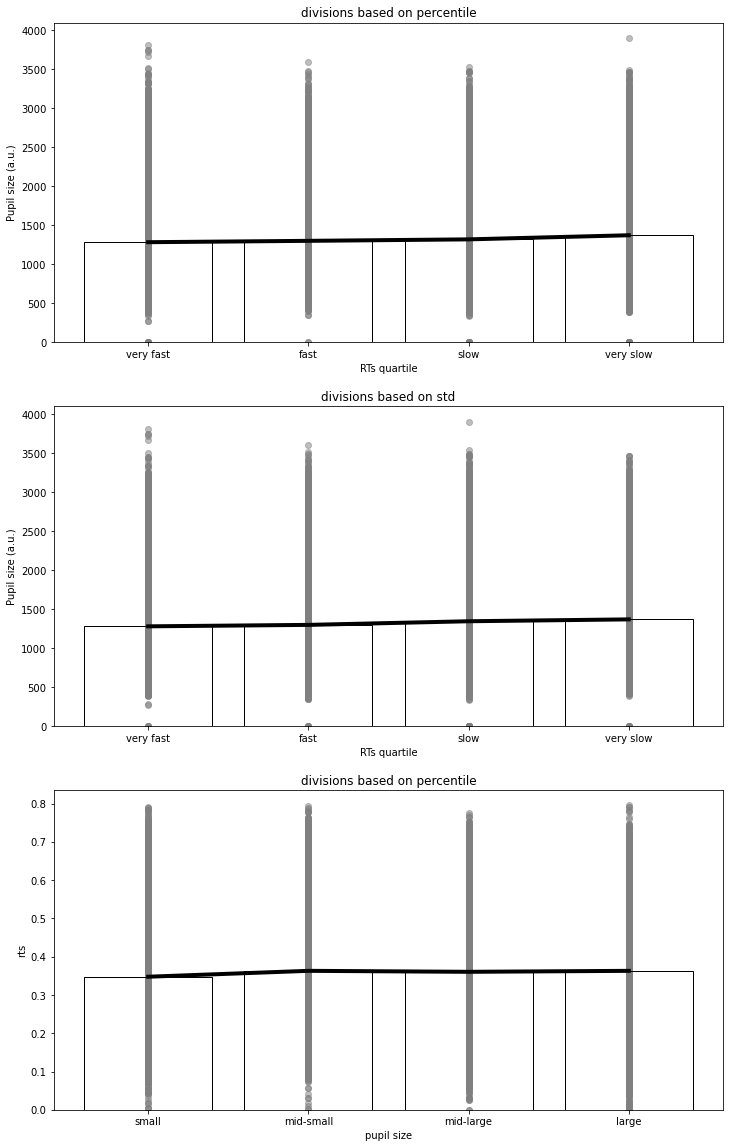

In [5]:
base_project_dir='/Users/pkeen/Documents/github/pupilometry_paper/'
project_dir = base_project_dir + 'expt2/'
subjects_dir = project_dir + 'subj_data/'
figure_dir = base_project_dir + 'paper_figs/'

#suppfig 2 - pupil and rt ,linear fit
fig = plt.figure(figsize=(12,20))
arf_reject = np.array(attndat.s_trailarf)
arf_reject[np.isnan(arf_reject)==1] = 1
rts_trail = np.array(attndat.rt_trail[arf_reject==0])
pupil_trail = np.array(attndat.s_trail[arf_reject==0])
nan_excludes = np.logical_and(np.isnan(rts_trail),np.isnan(pupil_trail))

#subplot1 - linear fit
#coefficients of best fit
#ax = plt.subplot(311)
#x1,b = np.polyfit(rts_trail[nan_excludes==0],pupil_trail[nan_excludes==0],1)
#ax.scatter(rts_trail,pupil_trail,color='grey',alpha=.5)
#best_fit_vals = [x1*i + b for i in rts_trail]
#ax.plot(rts_trail,best_fit_vals)
#violates assumption of linear independence, so least squares regression doesnt work

#subplot2 - quartiles
ax = plt.subplot(311)
[q1,q2,q3] = np.percentile(rts_trail[np.isnan(rts_trail)==0],[25,50,75])
psq1 = pupil_trail[rts_trail<=q1]
psq2 = pupil_trail[np.logical_and(rts_trail>q1,rts_trail<=q2)]
psq3 = pupil_trail[np.logical_and(rts_trail>q2,rts_trail<=q3)]
psq4 = pupil_trail[rts_trail>q3]
plt.scatter([np.ones(np.size(psq1))*1],[psq1],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq2))*2],[psq2],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq3))*3],[psq3],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq4))*4],[psq4],color = 'grey',alpha=0.5)
plt.bar([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],facecolor='none',edgecolor='k')
plt.plot([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],color='k',linewidth=4)
plt.xlabel('RTs quartile')
plt.xticks([1,2,3,4],['very fast','fast','slow','very slow'])
plt.ylabel("Pupil size (a.u.)")
plt.title('divisions based on percentile')

[t,p] = ttest_1samp(psq2,psq3,nan_policy='omit')
print(np.nanmean(p))
[t,p] = ttest_1samp(psq1,psq2,nan_policy='omit')
print("fast,very fast ",np.nanmean(p))
[t,p] = ttest_1samp(psq3,psq4,nan_policy='omit')
print("slow, very slow ",np.nanmean(p))
print("slope ",(np.nanmean(psq4)-np.nanmean(psq1))/(4-1))


#subplot 3 - sd deviations
ax = plt.subplot(312)
q1 = np.nanmean(rts_trail)-np.nanstd(rts_trail)
q2 = np.nanmean(rts_trail)
q3 = np.nanmean(rts_trail)+np.nanstd(rts_trail)
psq1 = pupil_trail[rts_trail<=q1]
psq2 = pupil_trail[np.logical_and(rts_trail>q1,rts_trail<=q2)]
psq3 = pupil_trail[np.logical_and(rts_trail>q2,rts_trail<=q3)]
psq4 = pupil_trail[rts_trail>q3]
plt.scatter([np.ones(np.size(psq1))*1],[psq1],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq2))*2],[psq2],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq3))*3],[psq3],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq4))*4],[psq4],color = 'grey',alpha=0.5)
plt.bar([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],facecolor='none',edgecolor='k')
plt.plot([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],color='k',linewidth=4)
plt.xlabel('RTs quartile')
plt.xticks([1,2,3,4],['very fast','fast','slow','very slow'])
plt.ylabel("Pupil size (a.u.)")
plt.title('divisions based on std')

#subplot 4 - do it for pupils
ax = plt.subplot(313)
[q1,q2,q3] = np.percentile(pupil_trail[np.isnan(pupil_trail)==0],[25,50,75])
psq1 = rts_trail[pupil_trail<=q1]
psq2 = rts_trail[np.logical_and(pupil_trail>q1,pupil_trail<q2)]
psq3 = rts_trail[np.logical_and(pupil_trail>q2,pupil_trail<=q3)]
psq4 = rts_trail[pupil_trail>q3]
plt.scatter([np.ones(np.size(psq1))*1],[psq1],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq2))*2],[psq2],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq3))*3],[psq3],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq4))*4],[psq4],color = 'grey',alpha=0.5)
plt.bar([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],facecolor='none',edgecolor='k')
plt.plot([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],color='k',linewidth=4)
plt.xlabel('pupil size')
plt.xticks([1,2,3,4],['small','mid-small','mid-large','large'])
plt.ylabel("rts")
plt.title('divisions based on percentile')

[t,p] = ttest_1samp(psq2,psq3,nan_policy='omit')
print(np.nanmean(p))
[t,p] = ttest_1samp(psq1,psq2,nan_policy='omit')
print("small,very small ",np.nanmean(p))
[t,p] = ttest_1samp(psq3,psq4,nan_policy='omit')
print("large, very large ",np.nanmean(p))
print("slope ",(np.nanmean(psq4)-np.nanmean(psq1))/(4-1))

fig.savefig(figure_dir + 'suppfig5-rt_pupil_relation_expt1.pdf', bbox_inches='tight')

0.00635300079484453
fast,very fast  0.003947537527547462
slow, very slow  0.005314185892237565
slope  -23.380232757485146
0.006360455356838007
small,very small  0.0058470274320749594
large, very large  0.005746406418346914
slope  -0.005972448169995852


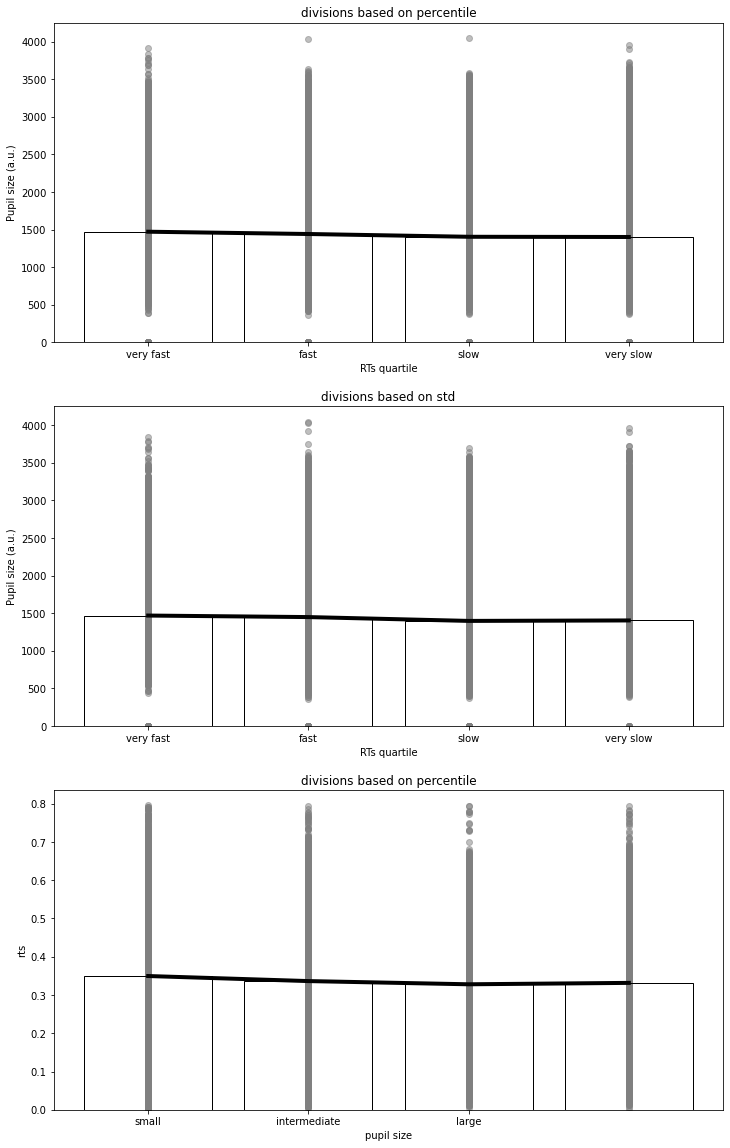

In [7]:
base_project_dir='/Users/pkeen/Documents/github/pupilometry_paper/'
project_dir = base_project_dir + 'expt2/'
subjects_dir = project_dir + 'subj_data/'
figure_dir = base_project_dir + 'paper_figs/'

#suppfig 2 - pupil and rt ,linear fit
fig = plt.figure(figsize=(12,20))
arf_reject = np.array(attndat2.s_trailarf)
arf_reject[np.isnan(arf_reject)==1] = 1
rts_trail = np.array(attndat2.rt_trail[arf_reject==0])
pupil_trail = np.array(attndat2.s_online_trail[arf_reject==0])
nan_excludes = np.logical_and(np.isnan(rts_trail),np.isnan(pupil_trail))

#subplot1 - linear fit
#coefficients of best fit
#ax = plt.subplot(311)
#x1,b = np.polyfit(rts_trail[nan_excludes==0],pupil_trail[nan_excludes==0],1)
#ax.scatter(rts_trail,pupil_trail,color='grey',alpha=.5)
#best_fit_vals = [x1*i + b for i in rts_trail]
#ax.plot(rts_trail,best_fit_vals)
#violates assumption of linear independence, so least squares regression doesnt work

#subplot2 - quartiles
ax = plt.subplot(311)
[q1,q2,q3] = np.percentile(rts_trail[np.isnan(rts_trail)==0],[25,50,75])
psq1 = pupil_trail[rts_trail<=q1]
psq2 = pupil_trail[np.logical_and(rts_trail>q1,rts_trail<=q2)]
psq3 = pupil_trail[np.logical_and(rts_trail>q2,rts_trail<=q3)]
psq4 = pupil_trail[rts_trail>q3]
plt.scatter([np.ones(np.size(psq1))*1],[psq1],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq2))*2],[psq2],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq3))*3],[psq3],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq4))*4],[psq4],color = 'grey',alpha=0.5)
plt.bar([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],facecolor='none',edgecolor='k')
plt.plot([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],color='k',linewidth=4)
plt.xlabel('RTs quartile')
plt.xticks([1,2,3,4],['very fast','fast','slow','very slow'])
plt.ylabel("Pupil size (a.u.)")
plt.title('divisions based on percentile')

[t,p] = ttest_1samp(psq2,psq3,nan_policy='omit')
print(np.nanmean(p))
[t,p] = ttest_1samp(psq1,psq2,nan_policy='omit')
print("fast,very fast ",np.nanmean(p))
[t,p] = ttest_1samp(psq3,psq4,nan_policy='omit')
print("slow, very slow ",np.nanmean(p))
print("slope ",(np.nanmean(psq4)-np.nanmean(psq1))/(4-1))


#subplot 3 - sd deviations
ax = plt.subplot(312)
q1 = np.nanmean(rts_trail)-np.nanstd(rts_trail)
q2 = np.nanmean(rts_trail)
q3 = np.nanmean(rts_trail)+np.nanstd(rts_trail)
psq1 = pupil_trail[rts_trail<=q1]
psq2 = pupil_trail[np.logical_and(rts_trail>q1,rts_trail<=q2)]
psq3 = pupil_trail[np.logical_and(rts_trail>q2,rts_trail<=q3)]
psq4 = pupil_trail[rts_trail>q3]
plt.scatter([np.ones(np.size(psq1))*1],[psq1],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq2))*2],[psq2],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq3))*3],[psq3],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq4))*4],[psq4],color = 'grey',alpha=0.5)
plt.bar([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],facecolor='none',edgecolor='k')
plt.plot([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],color='k',linewidth=4)
plt.xlabel('RTs quartile')
plt.xticks([1,2,3,4],['very fast','fast','slow','very slow'])
plt.ylabel("Pupil size (a.u.)")
plt.title('divisions based on std')

#subplot 4 - do it for pupils
ax = plt.subplot(313)
[q1,q2,q3] = np.percentile(pupil_trail[np.isnan(pupil_trail)==0],[25,50,75])
psq1 = rts_trail[pupil_trail<=q1]
psq2 = rts_trail[np.logical_and(pupil_trail>q1,pupil_trail<q2)]
psq3 = rts_trail[np.logical_and(pupil_trail>q2,pupil_trail<=q3)]
psq4 = rts_trail[pupil_trail>q3]
plt.scatter([np.ones(np.size(psq1))*1],[psq1],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq2))*2],[psq2],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq3))*3],[psq3],color = 'grey',alpha=0.5)
plt.scatter([np.ones(np.size(psq4))*4],[psq4],color = 'grey',alpha=0.5)
plt.bar([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],facecolor='none',edgecolor='k')
plt.plot([1,2,3,4],[np.nanmean(psq1),np.nanmean(psq2),np.nanmean(psq3),np.nanmean(psq4)],color='k',linewidth=4)
plt.xlabel('pupil size')
plt.xticks([1,2,3],['small','intermediate','large'])
plt.ylabel("rts")
plt.title('divisions based on percentile')

[t,p] = ttest_1samp(psq2,psq3,nan_policy='omit')
print(np.nanmean(p))
[t,p] = ttest_1samp(psq1,psq2,nan_policy='omit')
print("small,very small ",np.nanmean(p))
[t,p] = ttest_1samp(psq3,psq4,nan_policy='omit')
print("large, very large ",np.nanmean(p))
print("slope ",(np.nanmean(psq4)-np.nanmean(psq1))/(4-1))

fig.savefig(figure_dir + 'suppfig5-rt_pupil_relation.pdf', bbox_inches='tight')

<ipython-input-3-d3e23068d1f3>:20: RuntimeWarning: Mean of empty slice
  slow_threshagg = np.nanmean(slow_thresh,0)
<ipython-input-3-d3e23068d1f3>:21: RuntimeWarning: Mean of empty slice
  fast_threshagg = np.nanmean(fast_thresh,0)
<ipython-input-3-d3e23068d1f3>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(131)
c:\users\pkeen\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-3-d3e23068d1f3>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  

mean slow thresh 0.4928669564376786
mean fast thresh 0.26045511677451455
mean slow thresh std 0.011702482493902263
mean fast thresh std 0.010385222243640921


NameError: name 'figure_dir' is not defined

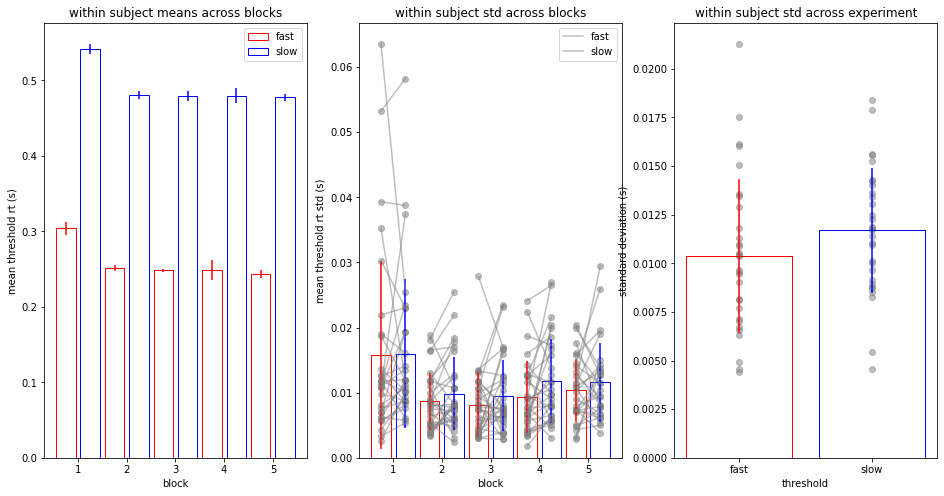

In [3]:
import scipy.stats as stats
#suppfig 3 - thresholds
isubj = 8 #chosen randomly
slow_thresh = np.zeros((nsubj,4000))
fast_thresh = np.zeros((nsubj,4000))
runningslowSTD = np.zeros((nsubj,4000))
runningfastSTD = np.zeros((nsubj,4000))
runningslowSTD[:] = np.nan
runningfastSTD[:] = np.nan
subj_blockslowstd = np.zeros((nsubj,5))
subj_blockfaststd = np.zeros((nsubj,5))
for isubj in range(nsubj):
    slow_thresh[isubj][:np.sum(attndat.subject_num==isubj)] = attndat.rt_slowthresh[attndat.subject_num==isubj]
    fast_thresh[isubj][:np.sum(attndat.subject_num==isubj)] = attndat.rt_fastthresh[attndat.subject_num==isubj]
    slow_thresh[isubj][slow_thresh[isubj]==0] = np.nan
    fast_thresh[isubj][fast_thresh[isubj]==0] = np.nan
    slow_thresh2 = attndat2.lowthresh[attndat2.subject_num==isubj]
    fast_thresh2 = attndat2.highthresh[attndat2.subject_num==isubj]

slow_threshagg = np.nanmean(slow_thresh,0)
fast_threshagg = np.nanmean(fast_thresh,0)


for i in np.arange(81,4000):
    runningslowSTD[isubj][i] = np.nanstd(slow_thresh[0:i])
    runningfastSTD[isubj][i] = np.nanstd(fast_thresh[0:i])

fig = plt.figure(figsize=(16,8))
# #gaussians
# ax = plt.subplot(3,2,1)
# mufast = np.nanmean(fast_thresh)
# sigmafast = np.nanstd(fast_thresh)
# muslow = np.nanmean(slow_thresh)
# sigmaslow = np.nanstd(slow_thresh)
# fastdist = np.linspace(mufast - 3*sigmafast, mufast + 3*sigmafast, 100)
# slowdist = np.linspace(muslow - 3*sigmaslow, muslow + 3*sigmaslow, 100)
# plt.plot(fastdist,stats.norm.pdf(fastdist,mufast,sigmafast),color='red')
# plt.plot(slowdist,stats.norm.pdf(slowdist,muslow,sigmaslow),color='blue')
# plt.legend(['fast','slow'])
# plt.xlabel('threshold rt value')
# plt.ylabel('# occurences')
# #gaussians
# ax = plt.subplot(3,2,2)
# mufast = np.nanmean(fast_thresh2)
# sigmafast = np.nanstd(fast_thresh2)
# muslow = np.nanmean(slow_thresh2)
# sigmaslow = np.nanstd(slow_thresh2)
# fastdist = np.linspace(mufast - 3*sigmafast, mufast + 3*sigmafast, 100)
# slowdist = np.linspace(muslow - 3*sigmaslow, muslow + 3*sigmaslow, 100)
# plt.plot(fastdist,stats.norm.pdf(fastdist,mufast,sigmafast),color='red')
# plt.plot(slowdist,stats.norm.pdf(slowdist,muslow,sigmaslow),color='blue')
# plt.legend(['large','small'])
# plt.xlabel('threshold pupil value')
# plt.ylabel('# occurences')
# #plot lines
# ax = plt.subplot(323)
# plt.plot(np.arange(0,4000),slow_thresh,color='blue')
# plt.plot(np.arange(0,4000),fast_thresh,color='red')
# plt.legend(['slow','fast'])
# plt.xlabel('trial number')
# plt.ylabel('rt')
# plt.axvline(x=800,c='k',)
# ax = plt.subplot(324)
# plt.plot(np.arange(0,4000),runningslowSTD,color='blue',linestyle='--')
# plt.plot(np.arange(0,4000),runningfastSTD,color='red',linestyle='--')
# plt.legend(['slow std','fast std'])
# plt.xlabel('trial number')
# plt.ylabel('rt')
#bars for each block
for i in range(5):
    blockfastmean = np.nanmean(fast_threshagg[(800*i):(800*(i+1))])
    blockslowmean = np.nanmean(slow_threshagg[(800*i):(800*(i+1))])
    blockslowstd = np.nanstd(slow_threshagg[(800*i):(800*(i+1))])
    blockfaststd = np.nanstd(fast_threshagg[(800*i):(800*(i+1))])
    for isubj in range(nsubj):
        subj_blockslowstd[isubj][i] = np.nanstd(slow_thresh[isubj][(800*i):(800*(i+1))])
        subj_blockfaststd[isubj][i] = np.nanstd(fast_thresh[isubj][(800*i):(800*(i+1))])
    ax = plt.subplot(131)
    plt.bar((2*i),blockfastmean,width=.8,color='white',edgecolor='red')
    plt.bar((2*i)+1,blockslowmean,width=.8,color='white',edgecolor='blue')
    plt.errorbar((2*i),blockfastmean,yerr=blockfaststd,color='red')
    plt.errorbar((2*i)+1,blockslowmean,yerr=blockslowstd,color='blue')
    
print("mean slow thresh",np.nanmean(np.nanmean(slow_thresh,1)))  
print("mean fast thresh",np.nanmean(np.nanmean(fast_thresh,1)))
print("mean slow thresh std",np.nanmean(np.nanmean(subj_blockslowstd,1)))
print("mean fast thresh std",np.nanmean(np.nanmean(subj_blockfaststd,1)))
ax = plt.subplot(132)
for i in range(5):
    plt.scatter(np.ones(nsubj)*(2*i),subj_blockfaststd[:,i],alpha=.5,color='grey')
    plt.scatter(np.ones(nsubj)*((2*i)+1),subj_blockslowstd[:,i],alpha=.5,color='grey')
    plt.plot([(2*i),(2*i)+1],[subj_blockfaststd[:,i],subj_blockslowstd[:,i]],alpha=.5,color='grey')
    plt.bar((2*i),np.nanmean(subj_blockfaststd[:,i],0),width=.8,color='none',edgecolor='red')
    plt.bar((2*i)+1,np.nanmean(subj_blockslowstd[:,i],0),width=.8,color='none',edgecolor='blue')
    plt.errorbar((2*i),np.nanmean(subj_blockfaststd[:,i],0),yerr=np.nanstd(subj_blockfaststd[:,i],0),color='red')
    plt.errorbar((2*i)+1,np.nanmean(subj_blockslowstd[:,i],0),yerr=np.nanstd(subj_blockslowstd[:,i],0),color='blue')
ax = plt.subplot(131) 
plt.xticks([.5,2.5,4.5,6.5,8.5],['1','2','3','4','5'])
plt.xlabel('block')
plt.ylabel('mean threshold rt (s)')
plt.legend(['fast','slow'])
plt.title('within subject means across blocks')
ax = plt.subplot(132) 
plt.xticks([.5,2.5,4.5,6.5,8.5],['1','2','3','4','5'])
plt.xlabel('block')
plt.ylabel('mean threshold rt std (s)')
plt.legend(['fast','slow'])
plt.title('within subject std across blocks')
ax = plt.subplot(133) 
plt.bar(1,np.nanmean(np.nanmean(subj_blockslowstd,1),0),width=.8,color='none',edgecolor='blue')
plt.bar(0,np.nanmean(np.nanmean(subj_blockfaststd,1),0),width=.8,color='none',edgecolor='red')
plt.scatter(np.ones(nsubj),np.nanmean(subj_blockslowstd,1),alpha=.5,color='grey')
plt.scatter(np.ones(nsubj)*0,np.nanmean(subj_blockfaststd,1),alpha=.5,color='grey')
plt.errorbar(0,np.nanmean(np.nanmean(subj_blockfaststd,1)),yerr=np.nanstd(np.nanmean(subj_blockfaststd,1),0),color='red')
plt.errorbar(1,np.nanmean(np.nanmean(subj_blockslowstd,1)),yerr=np.nanstd(np.nanmean(subj_blockslowstd,1),0),color='blue')
plt.xticks([0,1],['fast','slow'])
plt.xlabel('threshold')
plt.ylabel('standard deviation (s)')
plt.title('within subject std across experiment')
    
fig.savefig(figure_dir + 'suppfig6-rt_thresholds', bbox_inches='tight')



In [44]:
#correlate means of each threshold across subjects
r = np.zeros((nsubj,nsubj))
slowmeans = np.zeros((nsubj,2))
fastmeans = np.zeros((nsubj,2))
for isubj in range(nsubj):
    slowmeans[isubj] = [np.nanmean(slow_thresh[isubj][800:1600]),np.nanmean(slow_thresh[isubj][1600:2400])]
    fastmeans[isubj] = [np.nanmean(fast_thresh[isubj][800:1600]),np.nanmean(fast_thresh[isubj][1600:2400])]
rslow = spearmanr(slowmeans,axis=0,nan_policy='omit')[0]
print(rslow)
rfast = spearmanr(fastmeans,axis=0,nan_policy='omit')[0]
print(rfast)
#     for jsubj in range(nsubj):
#         r[isubj,jsubj] = spearmanr(np.concatenate([np.nanmean(slow_thresh[isubj][800:1600]),np.nanmean(fast_thresh[isubj][800:1600])]),np.concatenate([np.nanmean(slow_thresh[jsubj][1600:2400]),np.nanmean(fast_thresh[jsubj][1600:2400])]),nan_policy='omit')[0]
        
# fig = plt.figure(figsize=(12,10))
# ax = plt.gca()
# ax.imshow(r,cmap='hot',interpolation='nearest')
# for isubj in range(nsubj):
#     print(r[isubj,isubj])

0.8785317018909901
0.7935483870967741


1600